# Data import & data processing

<!DOCTYPE html>
<html>
<head>
    <title>Project Progress</title>
</head>
<body>
    <h1>Project Progress Overview</h1>
    <ul>
        <li><strong>Data Collection</strong>: A European index from 1998 to 2023, inflation, output gap, and main refinancing rate in Europe [?]</li>
        <li><strong>Scrapping and Data Cleaning and Consolidation</strong> [Done]</li>
        <li><strong>Calculating the Jaccard Similarity</strong> [Done] - Assigned to Gwen for improvement</li>
        <li><strong>Calculating the Pessimism Score for Every Period</strong> [Done]</li>
        <li><strong>Pessimism Score Improvement Using Hugo's Algorithm</strong> - Assigned to Hugo</li>
        <li><strong>Final DataFrame Construction</strong> - Assigned to Charaf</li>
        <li><strong>Calculating the Cumulative Abnormal Returns for the European Index</strong> - Assigned to Gwen</li>
        <li><strong>Regressing the Cumulative Abnormal Returns on Combinations of Pessimism Scores, Similarity, Inflation, Output Gap, and Main Refinancing Rates</strong> - Is this done? If not, assigned to Gwen</li>
        <li><strong>Analysing Non-Linearity in Cumulative Abnormal Returns</strong></li>
        <li><strong>Report Writing</strong></li>
        <li><strong>Preparing Slides for Presentation</strong></li>
    </ul>
</body>
</html>


In [5]:

import pandas as pd
import re
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
import itertools
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Web scrapping

In [108]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time

# Set up the WebDriver
driver = webdriver.Chrome()

# The target URL
url = 'https://www.ecb.europa.eu/press/pressconf/html/index.en.html'

# Open the page with Selenium
driver.get(url)

# Let the page load (wait for a few seconds if needed)
time.sleep(3)

# Get the page source and parse it with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Find all <dt> and <dd> tags which contain the date and the link respectively
dates = soup.find_all('dt', {'isodate': True})
statements = soup.find_all('dd')

# Initialize an empty list to store the data
data = []

# Iterate over the dates and statements
for date, statement in zip(dates, statements):
    # Extract date
    statement_date = date.div.text.strip()

    # Extract the link
    link_tag = statement.find('a')
    if link_tag and 'href' in link_tag.attrs:
        statement_url = 'https://www.ecb.europa.eu' + link_tag['href']

        # Use Selenium to open the statement page
        driver.get(statement_url)
        time.sleep(3)  # Wait for the page to load

        # Parse the opened page
        statement_soup = BeautifulSoup(driver.page_source, 'html.parser')
        # Extract content from the <main> tag
        statement_content = statement_soup.find('main').text.strip() if statement_soup.find('main') else ''

        # Append the data to the list
        data.append({
            'date': statement_date,
            'link': statement_url,
            'content': statement_content
        })

# Close the WebDriver
driver.quit()

# Create a DataFrame
df = pd.DataFrame(data)

# Now df contains the desired data



In [98]:
dates

[<dt isodate="2023-12-14"><div class="date">14 December 2023</div></dt>,
 <dt isodate="2023-10-26"><div class="date">26 October 2023</div></dt>,
 <dt isodate="2023-09-14"><div class="date">14 September 2023</div></dt>,
 <dt isodate="2023-07-27"><div class="date">27 July 2023</div></dt>,
 <dt isodate="2023-06-15"><div class="date">15 June 2023</div></dt>,
 <dt isodate="2023-05-04"><div class="date">4 May 2023</div></dt>,
 <dt isodate="2023-03-16"><div class="date">16 March 2023</div></dt>,
 <dt isodate="2023-02-02"><div class="date">2 February 2023</div></dt>]

In [97]:
statements

[<dd><div class="title"><a href="/press/pressconf/2023/html/ecb.is231214~df8627de60.en.html">Christine Lagarde, Luis de Guindos: Monetary policy statement (with Q&amp;A)</a></div><div class="subtitle">Christine Lagarde,  President of the ECB,  Luis de Guindos,  Vice-President of the ECB,  Frankfurt am Main,  14 December 2023</div><div class="ecb-langSelector"><span class="offeredLanguage"><a class="arrow" href="/press/pressconf/2023/html/ecb.is231214~df8627de60.en.html" lang="en">
 <span class="ecb-full">English</span></a></span><div class="moreLanguages">
 <span class="lnglabel">OTHER LANGUAGES</span>
 <span class="lang-counter">(23)</span>
 <span class="ecb-plus">+</span>
 </div>
 <div class="ecb-langPopup">
 <div class="ecb-closeBtn"></div>
 <div class="ecb-langHead">Select your language</div>
 <div class="otherlang"><a href="/press/pressconf/2023/html/ecb.is231214~df8627de60.bg.html" lang="bg">
 <span class="ecb-full">Български</span><span class="ecb-short">BG</span></a><a href="/p

# Data processing

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
ecb_statements = pd.read_csv('final_df.csv').drop('Date',axis=1)

#ecb_statements['date'] = pd.to_datetime(ecb_statements['date'], format='%d %B %Y')

# The 'date' column will now be in the numeric date format (yyyy-mm-dd)
# Display the DataFrame to verify
ecb_statements.head()
df_conf=ecb_statements
df_conf
df_conf['date']=pd.to_datetime(df_conf['date'],format='%Y-%m-%d')

 # Content cleaning
 

In [13]:
# Assuming df_conf is your DataFrame

# 1. Remove "Jump to the transcript" phrases
df_conf['content'] = df_conf['content'].str.replace("Jump to the transcript", "", regex=False)

# 2. Apply the text_cleansing function to each row in the 'content' column
def text_cleansing(text):
    index = text.find("answers")
    if index != -1:
        text_cleaned = text[index + len("answers"):].strip()
        split_phrases = [
            "We are now ready to take your questions.",
            "We are now at your disposal for questions.",
            "We are now at your disposal, should you have any questions.",
            "Transcript of the questions asked and the answers given by",
            "We stand ready to answer any questions you may have.",
            "CONTACT",
            "You may also be interested",
            "Related topics"
        ]
        for phrase in split_phrases:
            text_cleaned = text_cleaned.split(phrase)[0]
        return text_cleaned
    else:
        return text

df_conf['content'] = df_conf['content'].apply(text_cleansing)

# 3. Set the 'date' column as the index of the DataFrame
df_conf = df_conf.set_index('date')

# Additional operation (if required):
# Drop an entry without text content (if applicable)
# df_conf = df_conf.drop(index=[index_of_unnecessary_entry])


In [14]:

stops = list(stopwords.words('english'))


def clean(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = word_tokenize(x)
    x = [w for w in x if w not in stops]
    return(x)

df_conf['transform'] = [clean(i) for i in (df_conf['content'])]

stemmer = PorterStemmer()
df_conf['stem'] = df_conf['transform'].apply(lambda x: [stemmer.stem(token) for token in x])
df_conf

,Unnamed: 0,link,content,transform,stem
date,,,,,
2023-10-26,0,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-09-14,1,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-07-27,2,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-23,3,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-04,4,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
...,...,...,...,...,...
1998-11-03,270,https://www.ecb.europa.eu/press/pressconf/1998...,". \nLadies and gentlemen, as in previous month...","[ladies, gentlemen, previous, months, vicepres...","[ladi, gentlemen, previou, month, vicepresid, ..."
1998-10-13,271,https://www.ecb.europa.eu/press/pressconf/1998...,".\nLadies and gentlemen, in line with our stat...","[ladies, gentlemen, line, stated, intention, v...","[ladi, gentlemen, line, state, intent, vicepre..."
1998-09-01,272,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ..."


# SIMILARITY MEASURE

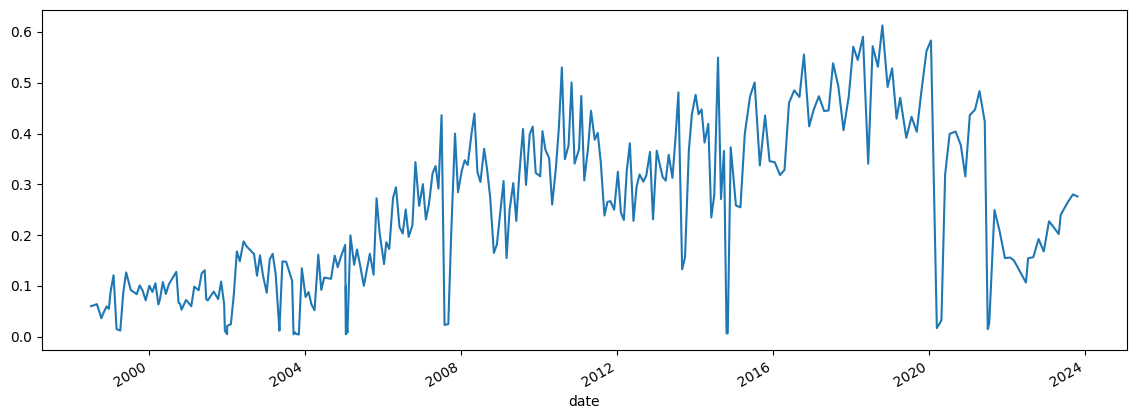

In [18]:
import pandas as pd
import numpy as np
from itertools import tee, islice
df_conf=df_conf.sort_values(by='date')
def jaccard_similarity(set_1, set_2):
    intersection = set_1.intersection(set_2)
    union = set_1.union(set_2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def find_bigrams(input_list):
    a, b = tee(input_list)
    next(b, None)
    return set(zip(a, b))

jaccard_similarities = [np.nan]  # 

# Iterate over the DataFrame and calculate Jaccard similarity for bigrams of successive speeches
for i in range(1, len(df_conf['stem'])):
    bigrams_i = find_bigrams(df_conf['stem'].iloc[i])
    bigrams_i_1 = find_bigrams(df_conf['stem'].iloc[i - 1])
    similarity = jaccard_similarity(bigrams_i, bigrams_i_1)
    jaccard_similarities.append(similarity)

# Add the similarity scores to the DataFrame
df_conf['jaccard_similarity'] = jaccard_similarities
plt.figure(figsize=(14,5))
df_conf.jaccard_similarity.plot()
plt.show()

# Pessimism Score


In [20]:
df_conf=df_conf.drop('Unnamed: 0',axis=1)

In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Assuming df_conf is your DataFrame
# Add two new columns for pessimism scores
df_conf['pessimism'] = np.NaN
df_conf['pessimism_2'] = np.NaN

# Load the Loughran-McDonald sentiment word lists
lm = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')
neg_list = set(lm[lm["Negative"] != 0]["Word"].str.lower())
pos_list = set(lm[lm["Positive"] != 0]["Word"].str.lower())

# Function to calculate pessimism
def calculate_pessimism(row):
    neg_words = [token for token in row['transform'] if token in neg_list]
    pos_words = [token for token in row['transform'] if token in pos_list]
    
    neg_count = len(neg_words)
    pos_count = len(pos_words)
    total_words = len(row['transform'])

    # Avoid division by zero
    if total_words == 0:
        return np.NaN, np.NaN

    pessimism_score = (neg_count - pos_count) / (neg_count + pos_count + 1e-10)
    pessimism_score_2 = (neg_count - pos_count) / total_words

    return pessimism_score, pessimism_score_2

# Apply the function to the DataFrame
pessimism_scores = df_conf.apply(calculate_pessimism, axis=1)
df_conf['pessimism'] = [score[0] for score in pessimism_scores]
df_conf['pessimism_2'] = [score[1] for score in pessimism_scores]


In [22]:
df_conf=df_conf.reset_index()

# Plotting


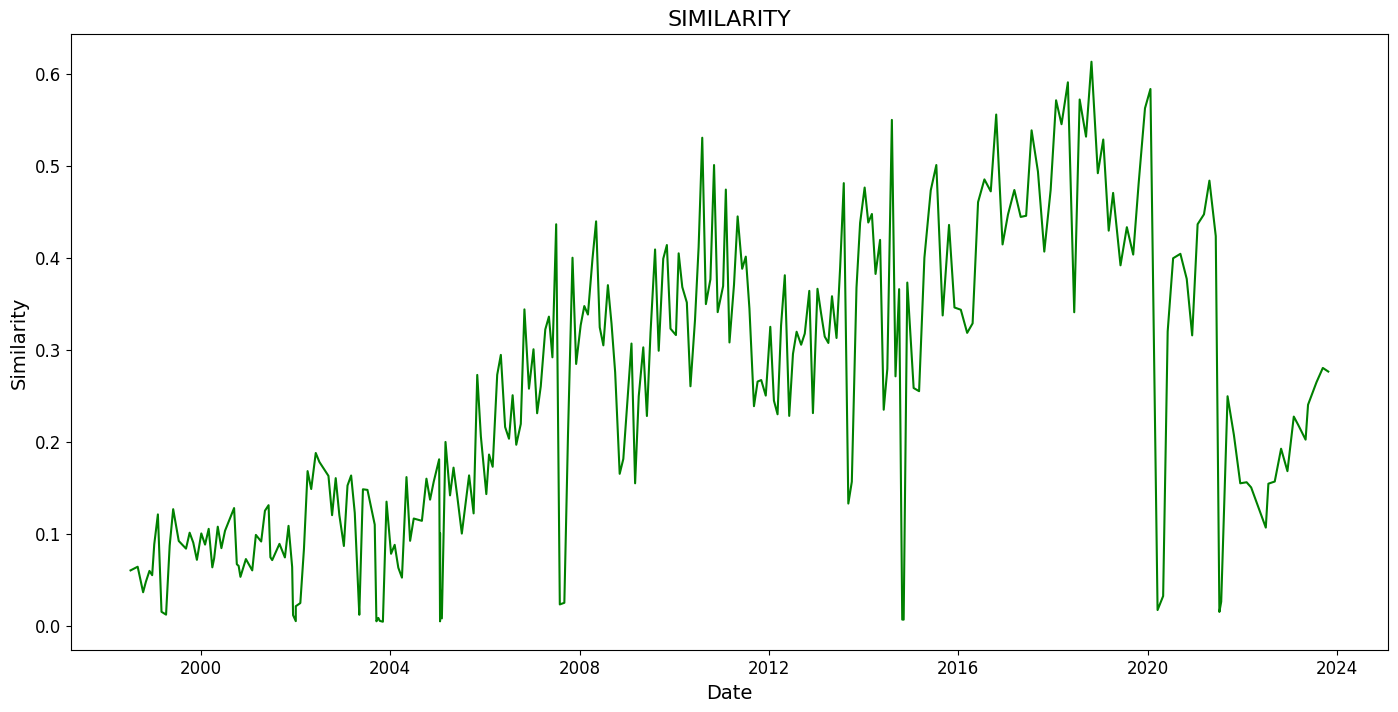

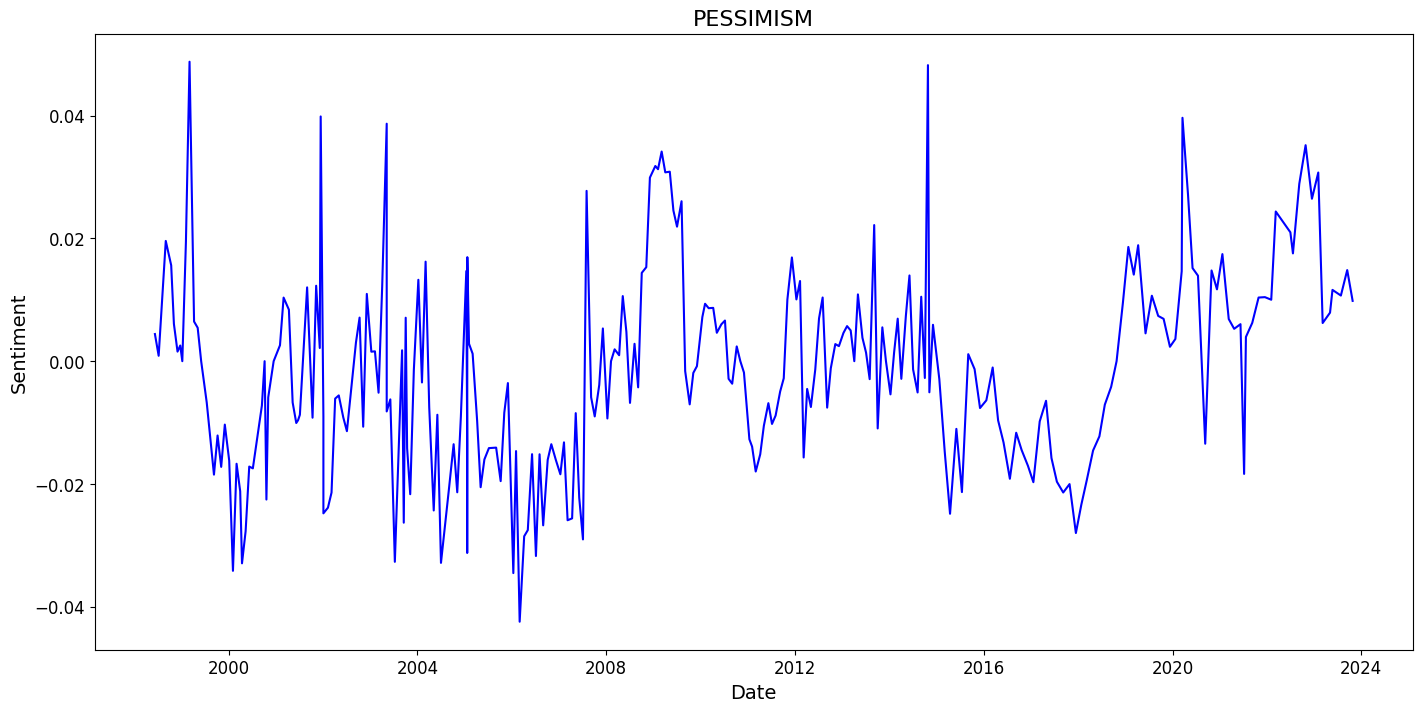

In [23]:
# plotting function to be applied to every measure
df_conf.rename(columns={'date': 'Date'}, inplace=True)
def plot_result(df, x, y, title, xlabel, ylabel, color):
    # Create a figure and set the size
    plt.figure(figsize=(17, 8))

    # Plot the specified columns using the specified color
    plt.plot(df[x], df[y], color=color)

    # Add a title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid()

    # Show the plot
    plt.show()


# Convert 'date' column to datetime format in date_2 just for visualisation
df_conf['date_2'] = pd.to_datetime(df_conf['Date'])


#plot  similarity
plot_result(df_conf, 'date_2', 'jaccard_similarity', 'SIMILARITY', 'Date', 'Similarity', 'green')
# plot sentiment_2 which the one used in the paper
plot_result(df_conf, 'date_2', 'pessimism_2', 'PESSIMISM', 'Date', 'Sentiment', 'blue')
#plot pessimism 1
#plot_result(df_conf, 'date_2', 'pessimism', 'PESSIMISM', 'Date', 'Sentiment', 'teal')


In [24]:
from datetime import datetime

def days_since_1999(date):
    start_date = datetime(1998, 6, 9)
    end_date = date
    return (end_date - start_date).days


dt = [days_since_1999(i) for i in df_conf['date_2']]
df_conf['diff'] = dt


reg_df = df_conf[['Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', 'diff']]
reg_df = reg_df.rename(columns={'date': 'Date'})

reg_df

,Date,jaccard_similarity,pessimism,pessimism_2,diff
0,1998-06-09,NaN,1.000000,0.004425,0
1,1998-07-08,0.060071,0.040000,0.000881,29
2,1998-09-01,0.064062,0.531915,0.019592,84
3,1998-10-13,0.036315,0.294798,0.015620,126
4,1998-11-03,0.047558,0.169811,0.006073,147
...,...,...,...,...,...
270,2023-05-04,0.202136,0.148936,0.007910,9095
271,2023-05-23,0.240066,0.214286,0.011617,9114
272,2023-07-27,0.264469,0.227273,0.010695,9179
273,2023-09-14,0.280069,0.291667,0.014846,9228


In [25]:
df_eurostock = pd.read_excel('MSCI EURO.xlsx')[['Date','Price']].sort_values(by='Date')
df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')
df_eurostock['last'] = list(map(lambda x: np.log(x), df_eurostock['Price']))
df_eurostock['pct_change'] = np.NaN
df_eurostock['pct_change'] = df_eurostock['last'].diff(1)

In [26]:
df_eurostock.tail(40)
df_eurostock.dropna(inplace=True)
df_eurostock_to_np = df_eurostock['pct_change'].to_numpy()
df_eurostock

,Date,Price,last,pct_change
7011,1997-01-01,549.766000,6.309493,0.000000
7010,1997-01-02,540.659000,6.292789,-0.016704
7009,1997-01-03,545.842000,6.302330,0.009541
7008,1997-01-06,549.316000,6.308674,0.006344
7007,1997-01-07,549.231000,6.308519,-0.000155
...,...,...,...,...
4,2023-11-10,1371.655134,7.223773,-0.007365
3,2023-11-13,1381.763593,7.231116,0.007343
2,2023-11-14,1402.400629,7.245941,0.014825
1,2023-11-15,1409.783286,7.251191,0.005250


# GETTING EUROSTOCK DATA

In [27]:



window_value_abnormal_return = {}
window_value_car = {}

df_eurostock['cumulate'] = np.NaN
df_eurostock['CAR'] = np.NaN

 
for n in (range(len(df_eurostock_to_np))):
    x = df_eurostock_to_np[n-251:n-50]
    window_value_abnormal_return[n] = 1/201*(np.sum(x))
liste_cumu = list(window_value_abnormal_return.values())
df_eurostock.cumulate = liste_cumu
df_eurostock['abnormal_return'] = np.NaN

 
df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - df_eurostock['cumulate']
df_eurostock_car_to_np = df_eurostock['abnormal_return'].to_numpy()

#  Computation of cumulative abnormal returns via the same method used above
for n in (range(len(df_eurostock_car_to_np))):
    x = df_eurostock_car_to_np[n-6:n+5]
    window_value_car[n] = np.sum(x)
liste_car= list(window_value_car.values())
df_eurostock.CAR = liste_car

df_eurostock['Date'] = df_eurostock['Date'].astype('datetime64[ns]')
df_eurostock.rename(columns = {'last':'eurostock_last','pct_change':'eurostock_pct_change','cumulate':'eurostock_cumulate',
                               'abnormal_return':'eurostock_abnormal_return', 'CAR':'eurostock_CAR'}, inplace = True)

df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# retrieving Eurostock CAR results in a new df
df_eurostock_final = df_eurostock.loc[:,['Date', 'eurostock_cumulate', 'eurostock_abnormal_return', 'eurostock_CAR']]
df_eurostock_final

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR
7011,1997-01-01,0.000309,-0.000309,0.000000
7010,1997-01-02,0.000297,-0.017001,0.000000
7009,1997-01-03,0.000323,0.009218,0.000000
7008,1997-01-06,0.000333,0.006011,0.000000
7007,1997-01-07,0.000338,-0.000493,0.000000
...,...,...,...,...
4,2023-11-10,0.000421,-0.007787,0.044410
3,2023-11-13,0.000381,0.006962,0.026850
2,2023-11-14,0.000370,0.014455,0.024388
1,2023-11-15,0.000392,0.004858,0.029241


In [28]:
df_hicp = pd.read_excel('Inflation & interest.xlsx')
df_hicp = df_hicp.rename(columns={'Unnamed: 0':'Date'})
df_hicp=df_hicp[['Date','Inflation']].sort_values(by='Date')
df_hicp.head()
df_hicp['Date'] = pd.to_datetime(df_hicp['Date'], format='%m/%Y').dt.strftime('%Y-%m')
df_hicp.Date = df_hicp.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_hicp['Date'] = df_hicp['Date'].astype('datetime64[ns]')

In [29]:
df_hicp=df_hicp.sort_values(by='Date')
df_hicp

,Date,Inflation
99,1998-12-01,1.358338
98,1999-03-01,0.761581
97,1999-06-01,0.971927
96,1999-09-01,1.167831
95,1999-12-01,1.646059
...,...,...
4,2022-09-01,9.447888
3,2022-12-01,10.058137
2,2023-03-01,8.936144
1,2023-06-01,6.913111


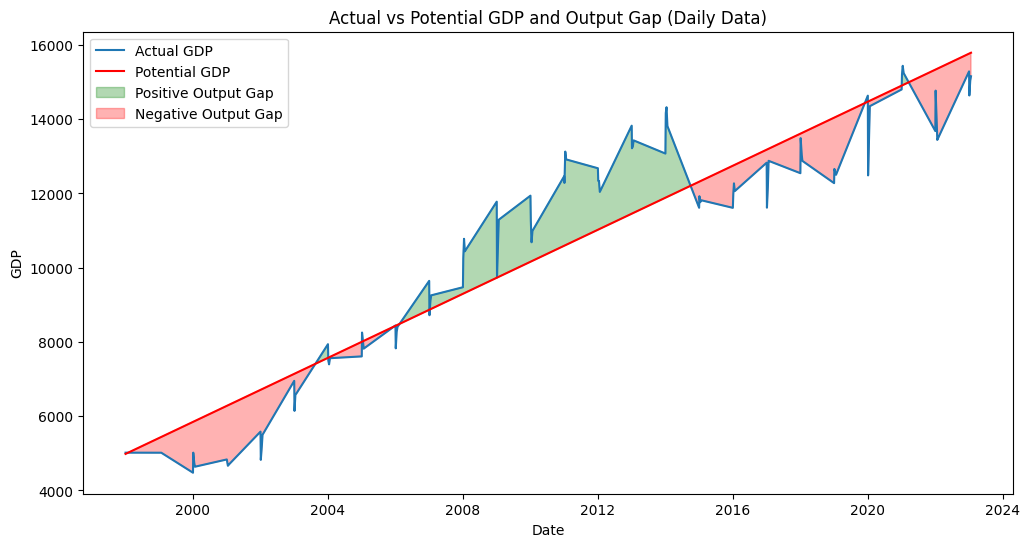

In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
def parse_quarter(string):
    quarter, year = string.split('/')
    month = (int(quarter[1]) - 1) * 3 + 1  # Convert quarter to start month
    return f'{year}-{month:02d}-01'

# Load and preprocess the data
df_gdp_llevel = pd.read_excel('Q GDP LEVEL.xlsx')
df_gdp_llevel['Date'] = df_gdp_llevel['Date'].apply(parse_quarter)
df_gdp_llevel['Date'] = pd.to_datetime(df_gdp_llevel['Date'], format='%Y-%d-%m')
df_gdp_llevel = df_gdp_llevel.set_index('Date')
df_gdp_llevel_daily = df_gdp_llevel['GDPL'].resample('D').mean()
df_gdp_llevel_daily_interpolated = df_gdp_llevel_daily.interpolate(method='linear')

# Fit a linear model to the daily interpolated data
model = LinearRegression()
X = np.arange(len(df_gdp_llevel_daily_interpolated)).reshape(-1, 1)  # Time as a feature
y = df_gdp_llevel_daily_interpolated.values  # GDP values
model.fit(X, y)

# Predict potential GDP on the daily data
potential_gdp_daily = model.predict(X)

# Calculate daily output gap
output_gap_daily = y - potential_gdp_daily

# Create a DataFrame for the results
df_results = pd.DataFrame({
    'Actual GDP': df_gdp_llevel_daily_interpolated,
    'Potential GDP': potential_gdp_daily,
    'Output Gap': output_gap_daily
}, index=df_gdp_llevel_daily_interpolated.index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['Actual GDP'], label='Actual GDP')
plt.plot(df_results.index, df_results['Potential GDP'], label='Potential GDP', color='red')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] > df_results['Potential GDP']), 
                 color='green', alpha=0.3, label='Positive Output Gap')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] <= df_results['Potential GDP']), 
                 color='red', alpha=0.3, label='Negative Output Gap')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Actual vs Potential GDP and Output Gap (Daily Data)')
plt.legend()
plt.show()


In [31]:
df_gdp_llevel_daily_interpolated

Date
1998-01-04     5018.907700
1998-01-05     5018.907700
1998-01-06     5018.907700
1998-01-07     5018.907700
1998-01-08     5018.907700
                  ...     
2023-01-21    15098.451328
2023-01-22    15113.028394
2023-01-23    15127.605459
2023-01-24    15142.182525
2023-01-25    15156.759591
Freq: D, Name: GDPL, Length: 9153, dtype: float64

In [32]:
df_gdp_llevel

,GDPL
Date,
2023-01-04,15289.098679
2023-01-25,15156.759591
2023-01-16,15025.566000
2023-01-07,14640.675000
2022-01-04,13680.895000
...,...
1999-01-04,5018.907700
1999-01-25,5018.907700
1999-01-16,5018.907700


import pandas as pd

# Function to convert quarter format to datetime
def parse_quarter(string):
    year, quarter = string.split('-')
    month = (int(quarter[1]) - 1) * 3 + 1  # Convert quarter to start month
    return f'{year}-{month:02d}-01'  # Return the first day of the start month

df_ogap = pd.read_csv('Q GDP.csv')
df_ogap = df_ogap.rename(columns={'TIME': 'Date'})
df_ogap['Date'] = df_ogap['Date'].apply(parse_quarter)  # Apply custom parsing function
df_ogap['Date'] = pd.to_datetime(df_ogap['Date'])  # Convert to datetime
df_ogap = df_ogap.set_index('Date')
df_ogap_daily = df_ogap['Gdp growth'].resample('D').mean()
df_ogap_daily = pd.DataFrame(df_ogap_daily.interpolate())



df_ogap_daily=df_ogap_daily.sort_values(by='Date')
# convert to YYYY-MM
df_ogap_daily.index = pd.to_datetime(df_ogap_daily.index, format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')
df_ogap_daily.Date = df_ogap_daily.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_ogap_daily['Date'] = df_ogap_daily['Date'].astype('datetime64[ns]')

In [33]:
df_ogap_daily =df_results['Output Gap']


# Merging all datasets 

In [34]:
 
## Convert monthly to daily for mro
from datetime import datetime
#import monthly and cleaning date columns
df_mro = pd.read_excel('Inflation & interest.xlsx')
df_mro = df_mro.rename(columns={'Unnamed: 0':'Date'})
# Convert the 'Date' column to a datetime format

# Append a default day to each date string and then convert to datetime
df_mro['Date'] = pd.to_datetime(df_mro['Date'].apply(lambda x: str(x) + '-01'), format='%m/%Y-%d')

# Set the 'Date' column as the index
df_mro = df_mro.set_index('Date')

# Resample and interpolate
df_mro_daily = df_mro.resample('D').mean()
df_mro_daily = df_mro_daily.interpolate()

# Reset the index and keep 'Date' as a column


df_mro['Rate'] = df_mro['LTR INT RATE'].astype(float)

#Interpolation to get daily MRO


In [35]:
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [36]:
df_ogap_daily=pd.DataFrame(df_ogap_daily, columns=[ 'Output Gap'])

In [37]:
df_ogap_daily=df_ogap_daily.reset_index()

In [72]:
## Create date column and convert it to dataframe
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

date_ = []
start_dt = date(1998, 12, 1)
end_dt = date(2023, 10, 26)
for dt in daterange(start_dt, end_dt):
    date_.append(dt.strftime("%Y-%m-%d"))
df_date = pd.DataFrame(date_, columns=['Date'])
df_date['Date'] = df_date['Date'].astype('datetime64[ns]')

In [52]:
df_mro_daily=df_mro_daily
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [73]:
stri=pd.read_csv('ecb data.csv')
stri=stri.rename(columns={'DATE':'Date'})
stri['Date'] = pd.to_datetime(stri['Date'])
stri = stri.set_index('Date')
stri_daily = stri.resample('D').mean()
stri_daily = stri_daily.interpolate()


In [74]:
stri_daily['STR']=stri_daily['STR'].astype('float')

In [76]:
df_final_not_clean

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,Inflation,Output Gap,STR,jaccard_similarity,pessimism,pessimism_2,date_2,diff,change_MRO_Rate,log_similarity,log_diff
2,1999-01-07,0.000444,-0.016597,-0.025643,1.113005,-401.272150,3.000000,0.088464,0.000000,0.000000,1999-01-07,212.0,NaN,-2.425165,5.356586
3,1999-02-04,0.000563,-0.001802,-0.033480,0.927347,-450.037932,2.915584,0.120927,0.428571,0.019455,1999-02-04,240.0,-0.084416,-2.112569,5.480639
4,1999-03-04,0.000270,0.011865,-0.018795,0.768440,-527.071635,2.733766,0.015087,0.622047,0.048796,1999-03-04,268.0,-0.181818,-4.193907,5.590987
5,1999-04-08,-0.000043,0.000567,0.039784,0.848463,-623.363765,2.506494,0.012000,0.166667,0.006462,1999-04-08,303.0,-0.227273,-4.422849,5.713733
6,1999-05-06,0.000121,-0.003924,-0.017575,0.912481,-700.397469,2.564286,0.086957,0.142857,0.005445,1999-05-06,331.0,0.057792,-2.442347,5.802118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2023-05-04,0.000528,-0.005958,-0.020587,7.528816,NaN,3.719388,0.202136,0.148936,0.007910,2023-05-04,9095.0,0.386054,-1.598813,9.115480
266,2023-05-23,0.000301,-0.008916,-0.008130,7.111016,NaN,3.827381,0.240066,0.214286,0.011617,2023-05-23,9114.0,0.107993,-1.426840,9.117567
267,2023-07-27,0.000646,0.019623,-0.014460,5.998742,NaN,4.214286,0.264469,0.227273,0.010695,2023-07-27,9179.0,0.386905,-1.330030,9.124674
268,2023-09-14,0.001219,0.011422,-0.008933,NaN,NaN,4.469388,0.280069,0.291667,0.014846,2023-09-14,9228.0,0.255102,-1.272720,9.129998


In [77]:
import warnings
warnings.filterwarnings("ignore")

## join date col & reg_df
df_not_clean = pd.merge(df_date,df_eurostock_final,how='left',on=['Date'])
df_not_clean_2 = pd.merge(df_not_clean,df_ogap_daily,how='left',on=['Date'])
df_not_clean_3 = pd.merge(df_not_clean_2,df_mro_daily,how='left',on=['Date'])
df_not_clean_4=df_not_clean_3.merge(stri_daily, on='Date',how='left')
df_conf.rename(columns={'date':'Date'}, inplace=True)
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')

df_final_not_clean = pd.merge(df_not_clean_4,df_conf,how='left',on=['Date'])

df_final_not_clean.set_index('Date', inplace=True)
df_final_not_clean.dropna(axis = 0, how = 'all', inplace = True)
df_final_not_clean.reset_index(inplace=True)

# Interpolate our variables with a daily granularity
df_final_not_clean.HICP = df_final_not_clean['Inflation'].interpolate()
df_final_not_clean.output_gap = df_final_not_clean['Output Gap'].interpolate()
df_final_not_clean.mro = df_final_not_clean['STR'].interpolate()

df_final_not_clean.dropna(subset= ['link'], inplace=True)

#df_final_not_clean = df_final_not_clean [['Date','jaccard_similarity','pessimism','pessimism_2','eurostock_cumulate','eurostock_abnormal_return', 'eurostock_CAR', 'Inflation', 'Gdp growth', 'mro', 'diff']]
df_final_not_clean = df_final_not_clean [['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Output Gap', 'STR',

       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff']]
df_final_not_clean.drop_duplicates(subset=['jaccard_similarity','diff'], inplace=True)

#Calculating MRO returns
df_final_not_clean['change_MRO_Rate'] = df_final_not_clean['STR'].diff(1)

#Calculating log for similarity and for Time variable (log_diff)
df_final_not_clean['log_similarity'] = np.log(df_final_not_clean['jaccard_similarity'])
df_final_not_clean['log_diff'] = np.log(df_final_not_clean['diff'].values)

# filling in the remaining missing data w/ latest value
df_final_not_clean.eurostock_cumulate.ffill(inplace=True)
df_final_not_clean.eurostock_abnormal_return.ffill(inplace=True)
df_final_not_clean.eurostock_CAR.ffill(inplace=True)


df_final_not_clean.reset_index(inplace=True, drop=True)
df_final_not_clean = df_final_not_clean[df_final_not_clean.Date > '1998-12-31']
df_final_not_clean

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,Inflation,Output Gap,STR,jaccard_similarity,pessimism,pessimism_2,date_2,diff,change_MRO_Rate,log_similarity,log_diff
2,1999-01-07,0.000444,-0.016597,-0.025643,1.113005,-401.272150,3.000000,0.088464,0.000000,0.000000,1999-01-07,212.0,NaN,-2.425165,5.356586
3,1999-02-04,0.000563,-0.001802,-0.033480,0.927347,-450.037932,2.915584,0.120927,0.428571,0.019455,1999-02-04,240.0,-0.084416,-2.112569,5.480639
4,1999-03-04,0.000270,0.011865,-0.018795,0.768440,-527.071635,2.733766,0.015087,0.622047,0.048796,1999-03-04,268.0,-0.181818,-4.193907,5.590987
5,1999-04-08,-0.000043,0.000567,0.039784,0.848463,-623.363765,2.506494,0.012000,0.166667,0.006462,1999-04-08,303.0,-0.227273,-4.422849,5.713733
6,1999-05-06,0.000121,-0.003924,-0.017575,0.912481,-700.397469,2.564286,0.086957,0.142857,0.005445,1999-05-06,331.0,0.057792,-2.442347,5.802118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2023-05-04,0.000528,-0.005958,-0.020587,7.528816,NaN,3.719388,0.202136,0.148936,0.007910,2023-05-04,9095.0,0.386054,-1.598813,9.115480
266,2023-05-23,0.000301,-0.008916,-0.008130,7.111016,NaN,3.827381,0.240066,0.214286,0.011617,2023-05-23,9114.0,0.107993,-1.426840,9.117567
267,2023-07-27,0.000646,0.019623,-0.014460,5.998742,NaN,4.214286,0.264469,0.227273,0.010695,2023-07-27,9179.0,0.386905,-1.330030,9.124674
268,2023-09-14,0.001219,0.011422,-0.008933,NaN,NaN,4.469388,0.280069,0.291667,0.014846,2023-09-14,9228.0,0.255102,-1.272720,9.129998


In [78]:
df_final_not_clean.isna().sum()

Date                         0
eurostock_cumulate           0
eurostock_abnormal_return    0
eurostock_CAR                0
Inflation                    2
Output Gap                   7
STR                          1
jaccard_similarity           0
pessimism                    0
pessimism_2                  0
date_2                       0
diff                         0
change_MRO_Rate              2
log_similarity               0
log_diff                     0
dtype: int64

In [79]:
df_final_not_clean.columns

Index(['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Output Gap', 'STR', 'jaccard_similarity',
       'pessimism', 'pessimism_2', 'date_2', 'diff', 'change_MRO_Rate',
       'log_similarity', 'log_diff'],
      dtype='object')

# Regression part of original paper (replication of results)

In [80]:
pip install Stargazer


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

#Creating a new df with replicate data
df_replicate = df_final_not_clean.ffill()

#exlude first row to avoid na
df_replicate = df_replicate.iloc[2:]

# fit linear regression
def fit_linear_regression(y,x):
    # Add a constant to the predictor variables
    x = sm.add_constant(x)

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# REPLICATING REGRESSION RESULTS OF TABLE 3 (in original paper)


In [87]:

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate['log_diff'].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['log_diff', 'Output Gap', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['diff','Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     12.45
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.23e-07
Time:                        04:02:46   Log-Likelihood:                -370.73
No. Observations:                 266   AIC:                             749.5
Df Residuals:                     262   BIC:                             763.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5312      0.109    -

In [90]:
# Creating a dataframe to summarize the new OLS regression results
new_ols_data = {
    "Model": ["(1)", "(2)", "(3)", "(4)"],
    "Adj. R-squared": [0.116, 0.278, 0.300, 0.116],
    "const coef": [-1.5282, -7.4334, -6.8601, -1.5282],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000],
    "log_diff coef": ["N/A", 0.7041, 0.6318, "N/A"],
    "log_diff P>|t|": ["N/A", 0.000, 0.000, "N/A"],
    "Output Gap coef": [0.0003, "N/A", 0.0002, 0.0003],
    "Output Gap P>|t|": [0.000, "N/A", 0.002, 0.000],
    "Inflation coef": [-0.0972, "N/A", "N/A", -0.0972],
    "Inflation P>|t|": [0.025, "N/A", "N/A", 0.025],
    "change_MRO_Rate coef": [1.4852, "N/A", 0.0912, 1.4852],
    "change_MRO_Rate P>|t|": [0.016, "N/A", 0.848, 0.016]
}

# Convert the dictionary into a DataFrame
new_ols_regression_comparison = pd.DataFrame(new_ols_data)
new_ols_regression_comparison



,Model,Adj. R-squared,const coef,const P>|t|,log_diff coef,log_diff P>|t|,Output Gap coef,Output Gap P>|t|,Inflation coef,Inflation P>|t|,change_MRO_Rate coef,change_MRO_Rate P>|t|
0,(1),0.116,-1.5282,0.0,N/A,N/A,0.0003,0.0,-0.0972,0.025,1.4852,0.016
1,(2),0.278,-7.4334,0.0,0.7041,0.0,N/A,N/A,N/A,N/A,N/A,N/A
2,(3),0.300,-6.8601,0.0,0.6318,0.0,0.0002,0.002,N/A,N/A,0.0912,0.848
3,(4),0.116,-1.5282,0.0,N/A,N/A,0.0003,0.0,-0.0972,0.025,1.4852,0.016


In [91]:


#calculating CAR absolute value
df_replicate['CAR_abs'] = df_replicate['eurostock_CAR'].abs()
#calculating interaction
df_replicate['interaction'] = df_replicate['pessimism'] * df_replicate['jaccard_similarity']

# We didn't include the Time (count) variable below

# REPLICATING REGRESSION RESULTS OF TABLE 4 (in original paper)

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['pessimism']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())
fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation']].dropna())

                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.714
Date:                Fri, 05 Jan 2024   Prob (F-statistic):              0.192
Time:                        12:05:23   Log-Likelihood:                 519.17
No. Observations:                 266   AIC:                            -1034.
Df Residuals:                     264   BIC:                            -1027.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0320      0.002     14.929      0.0

In [95]:
# Adding the new OLS regression results to the dataframe
new_data_3 = {
    "Model": ["(6)", "(7)", "(8)", "(9)", "(10)"],
    "Adj. R-squared": [0.003, 0.006, 0.002, 0.008, 0.002],
    "const coef": [0.0320, 0.0305, 0.0320, 0.0319, 0.0344],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000, 0.000],
    "pessimism coef": [0.0094, "N/A", "N/A", "N/A", "N/A"],
    "pessimism P>|t|": [0.192, "N/A", "N/A", "N/A", "N/A"],
    "interaction coef": ["N/A", "N/A", 0.0313, 0.0301, 0.0333],
    "interaction P>|t|": ["N/A", "N/A", 0.212, 0.247, 0.200],
    "Output Gap coef": ["N/A", 1.322e-06, "N/A", 1.012e-06, 1.746e-06],
    "Output Gap P>|t|": ["N/A", 0.507, "N/A", 0.615, 0.373],
    "Inflation coef": ["N/A", 0.0005, "N/A", 0.0001, -0.0012],
    "Inflation P>|t|": ["N/A", 0.725, "N/A", 0.944, 0.384],
    "change_MRO_Rate coef": ["N/A", -0.0357, "N/A", -0.0337, "N/A"],
    "change_MRO_Rate P>|t|": ["N/A", 0.095, "N/A", 0.116, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_3 = pd.DataFrame(new_data_3)

new_regression_comparison_3

,Model,Adj. R-squared,const coef,const P>|t|,pessimism coef,pessimism P>|t|,interaction coef,interaction P>|t|,Output Gap coef,Output Gap P>|t|,Inflation coef,Inflation P>|t|,change_MRO_Rate coef,change_MRO_Rate P>|t|
0,(6),0.003,0.0320,0.0,0.0094,0.192,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
1,(7),0.006,0.0305,0.0,N/A,N/A,N/A,N/A,0.000001,0.507,0.0005,0.725,-0.0357,0.095
2,(8),0.002,0.0320,0.0,N/A,N/A,0.0313,0.212,N/A,N/A,N/A,N/A,N/A,N/A
3,(9),0.008,0.0319,0.0,N/A,N/A,0.0301,0.247,0.000001,0.615,0.0001,0.944,-0.0337,0.116
4,(10),0.002,0.0344,0.0,N/A,N/A,0.0333,0.2,0.000002,0.373,-0.0012,0.384,N/A,N/A


In [97]:
new_regression_comparison_3.to_excel('Table 4 paper model.xlsx')

# Extension part of original paper  


In [98]:
 
df_final = df_final_not_clean.iloc[2:]
 

# Get the last row
last_row = df_final.tail(1)

# Drop the last row
df_final = df_final.drop(last_row.index)

# EXTENDING REGRESSION RESULTS OF TABLE 3

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final['log_diff'].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['log_diff']].ffill())

fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['Inflation']].ffill())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     12.49
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.17e-07
Time:                        12:32:31   Log-Likelihood:                -369.64
No. Observations:                 265   AIC:                             747.3
Df Residuals:                     261   BIC:                             761.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5282      0.110    -

In [102]:
# Adding the new OLS regression results to the dataframe
new_data_4 = {
    "Model": ["(11)", "(12)", "(13)", "(14)"],
    "Adj. R-squared": [0.116, 0.278, 0.278, 0.011],
    "const coef": [-1.5282, -7.4334, -7.4334, -1.5371],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000],
    "Output Gap coef": [0.0003, "N/A", "N/A", "N/A"],
    "Output Gap P>|t|": [0.000, "N/A", "N/A", "N/A"],
    "Inflation coef": [-0.0972, "N/A", "N/A", -0.0761],
    "Inflation P>|t|": [0.025, "N/A", "N/A", 0.050],
    "change_MRO_Rate coef": [1.4852, "N/A", "N/A", "N/A"],
    "change_MRO_Rate P>|t|": [0.016, "N/A", "N/A", "N/A"],
    "log_diff coef": ["N/A", 0.7041, 0.7041, "N/A"],
    "log_diff P>|t|": ["N/A", 0.000, 0.000, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_3 = pd.DataFrame(new_data_4)

new_regression_comparison_3.to_excel('Table 3 extension commun to all models.xlsx')


# EXTENDING REGRESSION RESULTS OF TABLE 4



In [103]:
#calculating CAR absolute value
df_final['CAR_abs'] = df_final['eurostock_CAR'].abs()
#calculating interaction
df_final['interaction'] = df_final['pessimism_2'] * df_final['jaccard_similarity'] 

# EXTENDING REGRESSION RESULTS OF TABLE 4
print('m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m1 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['pessimism_2']].ffill())
print('m2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m2 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())
print('m3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m3 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['interaction']].ffill())
print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m4 = fit_linear_regression(df_final['CAR_abs'].ffill(), df_final[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].ffill())
print('m5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap', 'Inflation', 'pessimism_2']].ffill())


m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.634
Date:                Fri, 05 Jan 2024   Prob (F-statistic):              0.106
Time:                        12:45:06   Log-Likelihood:                 517.23
No. Observations:                 265   AIC:                            -1030.
Df Residuals:                     263   BIC:                            -1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

import pandas as pd

In [105]:
# Adding the new OLS regression results (m1 to m5) to the dataframe
new_data_5 = {
    "Model": ["15", "16", "17", "18", "19"],
    "Adj. R-squared": [0.006, 0.006, 0.009, 0.013, 0.005],
    "const coef": [0.0320, 0.0305, 0.0321, 0.0324, 0.0348],
    "const P>|t|": [0.000, 0.000, 0.000, 0.000, 0.000],
    "pessimism_2 coef": [0.2132, "N/A", "N/A", "N/A", 0.0621],
    "pessimism_2 P>|t|": [0.106, "N/A", "N/A", "N/A", 0.772],
    "interaction coef": ["N/A", "N/A", 0.9707, 0.9240, 0.8191],
    "interaction P>|t|": ["N/A", "N/A", 0.069, 0.095, 0.347],
    "Output Gap coef": ["N/A", 1.323e-06, "N/A", 8.481e-07, 1.471e-06],
    "Output Gap P>|t|": ["N/A", 0.508, "N/A", 0.673, 0.456],
    "Inflation coef": ["N/A", 0.0005, "N/A", -8.893e-05, -0.0013],
    "Inflation P>|t|": ["N/A", 0.721, "N/A", 0.954, 0.336],
    "change_MRO_Rate coef": ["N/A", -0.0356, "N/A", -0.0316, "N/A"],
    "change_MRO_Rate P>|t|": ["N/A", 0.098, "N/A", 0.142, "N/A"]
}

# Convert the dictionary into a DataFrame and concatenate with the previous data
new_regression_comparison_5 = pd.DataFrame(new_data_5)

new_regression_comparison_5.to_excel('Table 4 extenstion for paper\'s model.xlsx')


# *****************************SUMMARY STATISTICS*****************************


In [68]:

def summarize_dataframe(df):
    summary = df.describe().T
    summary = summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return summary

summary = summarize_dataframe(df_final)
summary

,mean,std,min,25%,50%,75%,max
eurostock_cumulate,0.000031,0.000948,-0.003436,-0.000516,0.000207,0.000678,0.001922
eurostock_abnormal_return,-0.000956,0.017174,-0.134585,-0.007200,0.000802,0.007477,0.055791
eurostock_CAR,0.001864,0.046843,-0.355354,-0.016214,0.005526,0.026609,0.113426
Inflation,2.147691,1.640899,-0.128216,1.323364,2.054937,2.536062,9.883605
Output Gap,101.950746,1122.295018,-1880.570522,-791.653230,-113.878233,1228.463514,2295.613590
STR,2.125193,1.738896,0.000000,0.279003,1.483516,3.951803,4.469388
jaccard_similarity,0.255343,0.154884,0.004296,0.122006,0.257534,0.372832,0.612813
pessimism,-0.047679,0.295194,-0.724138,-0.277778,-0.046154,0.155556,0.755656
pessimism_2,-0.001817,0.016158,-0.042453,-0.013527,-0.002786,0.007376,0.048796
diff,4352.981132,2500.963424,268.000000,2214.000000,4195.000000,6246.000000,9228.000000


# Capture non-linearity

In [69]:
  
def square_column(df, col):
    df['square_' + col] = df[col] ** 2

#apply var² on Time var (diff)
square_column(df_final, 'diff')

# after ² we apply log
df_final['log_square_diff'] = np.log(df_final['square_diff'])

#apply var² to Similarity
square_column(df_final, 'jaccard_similarity')

#apply var² to INFLATION
square_column(df_final, 'Inflation')
 
def fit_linear_regression_nc(y,x):

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# CAPTURING NON-LINEARITY ON SIMILARITY & INFLATION


In [71]:
m1 = fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['log_diff', 'log_square_diff']].ffill())

m2 = fit_linear_regression(df_final['log_similarity'].ffill(), df_final[['square_Inflation', 'Inflation']].ffill())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     102.5
Date:                Fri, 05 Jan 2024   Prob (F-statistic):           1.46e-20
Time:                        01:53:53   Log-Likelihood:                -343.81
No. Observations:                 265   AIC:                             691.6
Df Residuals:                     263   BIC:                             698.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.4334      0.569    -

# CAPTURING NON-LINEARITY ON 


In [193]:



m1 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['jaccard_similarity', 'square_jaccard_similarity']].dropna())
# w/o constant
m2 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['interaction',  'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction',  'Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())

m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap']].dropna())

                                 OLS Regression Results                                
Dep. Variable:                CAR_abs   R-squared (uncentered):                   0.413
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                              89.26
Date:                Thu, 04 Jan 2024   Prob (F-statistic):                    4.38e-30
Time:                        01:25:27   Log-Likelihood:                          485.14
No. Observations:                 256   AIC:                                     -966.3
Df Residuals:                     254   BIC:                                     -959.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------